In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random
import itertools
import re
import torch.optim as optim
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

In [3]:
CHARS = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L",
         "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
C2I_MAPPING = {c: i for i, c in enumerate(CHARS)}


# given two seqeuneces, find mutational distance in between and return indexes where a mutation occurs
def cal_dist_seq(seq1, seq2):
    dist = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            dist += 1
    return dist


def compute_log_conditional_probs(seq, tokenizer, model):
    """
    Given a single sequence, compute the log-probability
    of its true amino acid at each position i, conditioned
    on masking that position.
    Returns:
        logps: np.array of shape (L,) where L = len(seq)
    """
    L = len(seq)
    logps = np.zeros(L, dtype=np.float32)
    # add BOS/EOS tokens automatically
    for i in range(L):
        masked = list(seq)
        masked[i] = tokenizer.mask_token
        toks = tokenizer("".join(masked),
                         return_tensors="pt",
                         add_special_tokens=True,
                         truncation=True).to(device)
        with torch.no_grad():
            out = model(**toks).logits  # shape (1, T, V)
            # token index = i+1 (after BOS)
            token_idx = i + 1
            # get log‐softmax over vocab at that position
            log_probs = F.log_softmax(out[0, token_idx], dim=-1)
            true_id = tokenizer.convert_tokens_to_ids(seq[i])
            logps[i] = log_probs[true_id].item()
    return logps

In [4]:
class SingleRR(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.1):
        """
        SingleRR model for a single embedding regression (ridge regression).

        Args:
            embedding_dim (int): Dimension of the input embedding.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(SingleRR, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        # Linear layer outputs a single value per sample.
        self.linear = nn.Linear(embedding_dim, 1)

    def forward(self, emb):
        """
        Args:
            emb (torch.Tensor): Tensor of shape (N, embedding_dim)

        Returns:
            logits (torch.Tensor): Tensor of shape (N,), representing the predicted continuous score.
        """
        x = self.dropout(emb)
        logits = self.linear(x)  # shape: (N, 1)
        return logits.squeeze(1)  # shape: (N,)

In [5]:
def load_data_single(emb, labels, batch, batch_size, device):
    """
    Loads a batch of data from the single-embedding dataset.

    Args:
        emb (np.ndarray): Array of shape (N, embedding_dim).
        labels (np.ndarray): Array of shape (N,) with continuous targets.
        batch (int): current batch index (starting from 0).
        batch_size (int)
        device (torch.device)

    Returns:
        data_batch (torch.Tensor): Tensor of shape (batch_size, embedding_dim)
        labels_batch (torch.Tensor): Tensor of shape (batch_size,)
    """
    if (batch+1)*batch_size > len(labels):
        idx = np.arange(batch*batch_size, len(labels))
    else:
        idx = np.arange(batch*batch_size, (batch+1)*batch_size)
    data_batch = emb[idx]
    labels_batch = labels[idx]
    data_batch = torch.from_numpy(data_batch).to(torch.float32).to(device)
    labels_batch = torch.from_numpy(labels_batch).to(torch.float32).to(device)
    return data_batch, labels_batch


def train_epoch_single(model, optimizer, emb, labels, batch_size, device):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total_samples = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    for batch in range(num_batches):
        data_batch, labels_batch = load_data_single(emb, labels, batch, batch_size, device)
        preds = model(data_batch)
        loss = criterion(preds, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data_batch.size(0)
        total_samples += data_batch.size(0)
        all_preds.append(preds)
        all_targets.append(labels_batch)
    avg_loss = running_loss / total_samples
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    spearman_corr, _ = spearmanr(all_preds.detach().cpu().numpy(), all_targets.detach().cpu().numpy())
    return avg_loss, spearman_corr


def test_epoch_single(model, emb, labels, batch_size, device):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total_samples = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    with torch.no_grad():
        for batch in range(num_batches):
            data_batch, labels_batch = load_data_single(emb, labels, batch, batch_size, device)
            preds = model(data_batch)
            loss = criterion(preds, labels_batch)
            running_loss += loss.item() * data_batch.size(0)
            total_samples += data_batch.size(0)
            all_preds.append(preds)
            all_targets.append(labels_batch)
    avg_loss = running_loss / total_samples
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    # Compute Spearman correlation (convert to numpy arrays)
    spearman_corr, _ = spearmanr(all_preds.cpu().numpy(), all_targets.cpu().numpy())
    return avg_loss, spearman_corr, all_preds, all_targets

# Re-train the SingleRR model on the entire dataset

Epoch   1 ▶ Train Loss 3.2436 | Spear 0.2629
Epoch   2 ▶ Train Loss 2.7872 | Spear 0.4417
Epoch   3 ▶ Train Loss 2.6334 | Spear 0.4808
Epoch   4 ▶ Train Loss 2.5640 | Spear 0.5092
Epoch   5 ▶ Train Loss 2.4290 | Spear 0.5483
Epoch   6 ▶ Train Loss 2.3288 | Spear 0.5744
Epoch   7 ▶ Train Loss 2.3001 | Spear 0.5788
Epoch   8 ▶ Train Loss 2.2311 | Spear 0.6002
Epoch   9 ▶ Train Loss 2.1872 | Spear 0.6108
Epoch  10 ▶ Train Loss 2.1877 | Spear 0.6072
Epoch  11 ▶ Train Loss 2.1284 | Spear 0.6276
Epoch  12 ▶ Train Loss 2.0827 | Spear 0.6330
Epoch  13 ▶ Train Loss 2.0619 | Spear 0.6372
Epoch  14 ▶ Train Loss 2.0438 | Spear 0.6374
Epoch  15 ▶ Train Loss 2.0335 | Spear 0.6459
Epoch  16 ▶ Train Loss 1.9978 | Spear 0.6509
Epoch  17 ▶ Train Loss 1.9808 | Spear 0.6539
Epoch  18 ▶ Train Loss 1.9608 | Spear 0.6564
Epoch  19 ▶ Train Loss 1.9372 | Spear 0.6655
Epoch  20 ▶ Train Loss 1.9871 | Spear 0.6533
Epoch  21 ▶ Train Loss 1.9352 | Spear 0.6669
Epoch  22 ▶ Train Loss 1.8884 | Spear 0.6684
Epoch  23 

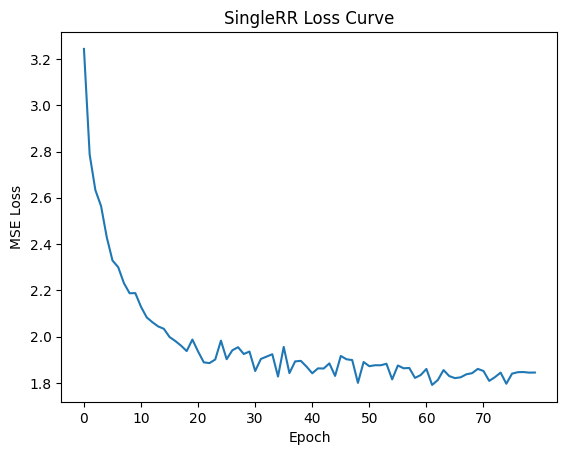

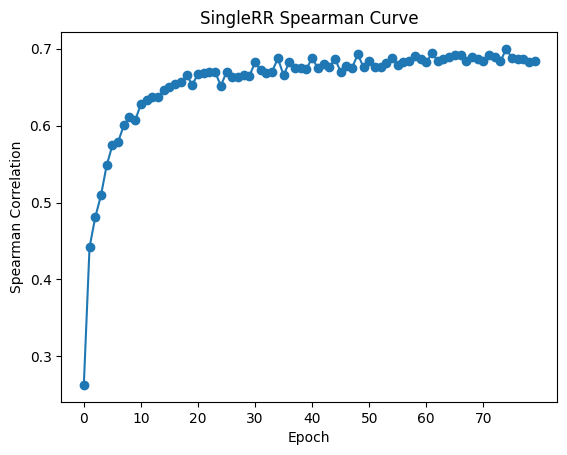

In [6]:
batch_size    = 16
n_epoch       = 80
embedding_dim = 1882
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SingleRR(embedding_dim, dropout_rate=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


# --- load & preprocess data ---
AAindex = np.load("/content/drive/MyDrive/Mid_1_data_train/AAindex_emb_r3.npy")
PLL = np.load("/content/drive/MyDrive/Mid_1_data_train/PLL_r3.npy")
train_df = pd.read_csv('/content/drive/MyDrive/Mid_1_data_train/data_single_train_r3.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Mid_1_data_train/data_single_test_r3.csv')
df = pd.concat([train_df, test_df]).reset_index(drop=True)
seq2idx = pickle.load(open('/content/drive/MyDrive/Mid_1_data_train/seq_to_index_r3.pkl', 'rb'))

idx = [seq2idx[seq.rstrip('*')] for seq in list(df['seq'])]

emb = np.concatenate((AAindex[np.array(idx)], PLL[np.array(idx)]), axis=1)
labels = np.array(list(df['fitness']))


# --- training loop ---

train_losses = []
train_spears  = []

for epoch in range(1, n_epoch+1):
    train_loss, train_spear = train_epoch_single(model, optimizer, emb, labels, batch_size, device)
    train_losses.append(train_loss)
    train_spears.append(train_spear)

    print(f"Epoch {epoch:3d} ▶ Train Loss {train_loss:.4f} | Spear {train_spear:.4f}")

torch.save(model.state_dict(), "/content/drive/MyDrive/Mid_1_RR_results/SingleRR_inference.pt")



# --- plot loss & Spearman curves ---
epochs = range(len(train_losses))
ticks  = np.arange(0, len(train_losses), 10)

plt.figure()
plt.plot(epochs, train_losses)
plt.xticks(ticks)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"SingleRR Loss Curve")
plt.savefig("/content/drive/MyDrive/Mid_1_RR_results/SingleRR_loss_inference.png")

plt.figure()
plt.plot(epochs, train_spears, marker='o')
plt.xticks(ticks)
plt.xlabel("Epoch")
plt.ylabel("Spearman Correlation")
plt.title(f"SingleRR Spearman Curve")
plt.savefig("/content/drive/MyDrive/Mid_1_RR_results/SingleRR_spearman_inference.png")
plt.show()

# Inference on point mutations

In [8]:
# 1) Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SingleRR(1882, dropout_rate=0.1).to(device)
checkpoint = "/content/drive/MyDrive/Mid_1_RR_results/SingleRR_inference.pt"
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

# 2) Prepare AAIndex embedding and ESM2 for PLL calculation
aaindex_ref = np.load(f'/content/drive/MyDrive/Mid_1_data/aaindex-pca-19.npy')
scaler = StandardScaler()
aaindex_ref = scaler.fit_transform(aaindex_ref)

esm_model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_model_name, do_lower_case=False)
esm = AutoModelForMaskedLM.from_pretrained(esm_model_name).to(device)
esm.eval()

# 3) Build all point‐mutants of the reference seq
ref_seq = "MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQLTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLTEKTLQLMKEYFQQSD"
aas = list("ACDEFGHIKLMNPQRSTVWY")

variants = []
mutations = []
L = len(ref_seq)
for i, wt in enumerate(ref_seq):
    for aa in aas:
        if aa == wt:
            continue
        var = ref_seq[:i] + aa + ref_seq[i+1:]
        variants.append(var)
        mutations.append(f"{wt}{i-3}{aa}")

# include the wild‐type itself
variants.insert(0, ref_seq)
mutations.insert(0, "")

# 4) Calculate PLL for the ref seq
P_ref = compute_log_conditional_probs(ref_seq, tokenizer, esm)


# 5) Batch‐infer all variants
batch_size = 32
results = []

for start in tqdm(range(0, len(variants), batch_size), desc="Inferring variants"):
    end = min(start + batch_size, len(variants))
    batch_seqs = variants[start:end]
    batch_muts = mutations[start:end]

    # AAIndex embed batch variants
    int_seqs = []
    for i in range(len(batch_seqs)):
        seq = batch_seqs[i]
        int_seq = [C2I_MAPPING[seq[j]] for j in range(len(seq))]
        int_seqs.append(int_seq)
    int_seqs = np.array(int_seqs)
    # shape: B * L * 19
    aaindex_emb = aaindex_ref[int_seqs]
    # shape: B * (L*19)
    aaindex_emb = aaindex_emb.reshape(aaindex_emb.shape[0], -1)

    # calculate the PLL for batch variants
    PLL = np.zeros((len(batch_seqs), 1), dtype=np.float32)
    for idx, seq in tqdm(enumerate(batch_seqs)):
        # find mutated positions
        muts = [i for i, (a, b) in enumerate(zip(seq, ref_seq)) if a != b]
        if not muts:
            PLL[idx, 0] = 0.0
            continue
        # compute log‐probs for each mutated position
        logp_mut = 0.0
        for i in muts:
            masked = list(seq)
            masked[i] = tokenizer.mask_token
            toks = tokenizer("".join(masked),
                            return_tensors="pt",
                            add_special_tokens=True,
                            truncation=True).to(device)
            with torch.no_grad():
                out = esm(**toks).logits
                log_probs = F.log_softmax(out[0, i+1], dim=-1)
                true_id = tokenizer.convert_tokens_to_ids(seq[i])
                logp_mut += log_probs[true_id].item()
        # PLL = sum logp_mutated – sum P_wt at those positions
        PLL[idx, 0] = logp_mut - P_ref[muts].sum()

    # prepare emb
    emb = np.concatenate((aaindex_emb, PLL), axis=1)
    emb = torch.from_numpy(emb).to(torch.float32).to(device)

    # predict
    with torch.no_grad():
        preds = model(emb)               # (B,)

    for seq, mut, score in zip(batch_seqs, batch_muts, preds.cpu().numpy()):
        results.append({
            "sequence": seq,
            "mutation": mut,
            "predicted_fitness": score
        })

# 6) Rank & save
df_out = pd.DataFrame(results)
df_out = df_out.sort_values(
    "predicted_fitness",
    ascending=False
).reset_index(drop=True)

out_csv = "/content/drive/MyDrive/Mid_1_RR_results/mid13sc_point_mut_results.csv"
df_out.to_csv(out_csv, index=False)
print(f"Saved {len(df_out)} variants to {out_csv}")

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Inferring variants:   0%|          | 0/59 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00,  4.69it/s]
3it [00:00,  3.35it/s]
4it [00:01,  2.91it/s]
5it [00:01,  2.69it/s]
6it [00:02,  2.58it/s]
7it [00:02,  2.50it/s]
8it [00:02,  2.44

Saved 1882 variants to /content/drive/MyDrive/Mid_1_RR_results/mid13sc_point_mut_results.csv


# Inference for Doublets & Triplets

In [6]:
# 1) Load the previous single‐mutant results and pick top 30 (excluding wildtype)
df_single = pd.read_csv(
    "/content/drive/MyDrive/Mid_1_RR_results/mid13sc_point_mut_results.csv"
)
# exclude the wild‐type entry which has empty mutation string
df_filtered = df_single[df_single['mutation'] != ""].reset_index(drop=True)
top30 = df_filtered.head(30)
mut_list = top30['mutation'].tolist()

# 2) Generate all doublet & triplet combinations (only if positions differ)
#    parse mutation strings like "M1D" → (ref_aa, pos, alt_aa)
mut_pattern = re.compile(r'^([A-Z])(\d+)([A-Z])$')

def parse_mut(mut_str):
    """
    Given a mutation string like "G50A", parse into:
      (0‐based position, new_amino_acid).
    According to the new scheme, the integer in the middle is offset by –3,
    so actual_index = int(number) + 3.
    """
    m = mut_pattern.match(mut_str)
    if m is None:
        raise ValueError(f"Unrecognized mutation format: {mut_str}")
    raw_num = int(m.group(2))
    actual_idx = raw_num + 3           # offset by –3 → +3 here
    new_aa = m.group(3)
    return (actual_idx, new_aa)

# Pre‐parse to tuples for fast checks
parsed = [parse_mut(m) for m in mut_list]
# Keep track of original mutation strings in same order
mutation_to_parsed = dict(zip(mut_list, parsed))


# Build valid combos
doublets = [
    combo for combo in itertools.combinations(mut_list, 2)
    if mutation_to_parsed[combo[0]][0] != mutation_to_parsed[combo[1]][0]
]
triplets = [
    combo for combo in itertools.combinations(mut_list, 3)
    if len({mutation_to_parsed[m][0] for m in combo}) == 3
]
all_combos = doublets + triplets

# 3) Apply mutations to the reference sequence
ref_seq = "MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQLTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLTEKTLQLMKEYFQQSD"

def apply_mutations(ref, muts):
    arr = list(ref)
    for mut in muts:
        pos, new_aa = mutation_to_parsed[mut]
        arr[pos] = new_aa
    return "".join(arr)

variants   = [apply_mutations(ref_seq, combo) for combo in all_combos]
mut_strs   = [",".join(combo) for combo in all_combos]

# 4) Load model & ESM embedder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re‐load SingleRR model
model = SingleRR(1882, dropout_rate=0.1).to(device)
checkpoint = "/content/drive/MyDrive/Mid_1_RR_results/SingleRR_inference.pt"
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

# Re‐load AAIndex embedding and ESM2
aaindex_ref = np.load(f'/content/drive/MyDrive/Mid_1_data/aaindex-pca-19.npy')
scaler = StandardScaler()
aaindex_ref = scaler.fit_transform(aaindex_ref)

esm_model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_model_name, do_lower_case=False)
esm = AutoModelForMaskedLM.from_pretrained(esm_model_name).to(device)
esm.eval()

# Calculate PLL for the ref seq
P_ref = compute_log_conditional_probs(ref_seq, tokenizer, esm)



# 5) Batch‐embed & predict all combos
batch_size = 32
results = []

for start in tqdm(range(0, len(variants), batch_size), desc="Doublet/Triplet inference"):
    end = min(start + batch_size, len(variants))
    batch_seqs = variants[start:end]
    batch_muts = mut_strs[start:end]

    # AAIndex embed batch variants
    int_seqs = []
    for i in range(len(batch_seqs)):
        seq = batch_seqs[i]
        int_seq = [C2I_MAPPING[seq[j]] for j in range(len(seq))]
        int_seqs.append(int_seq)
    int_seqs = np.array(int_seqs)
    # shape: B * L * 19
    aaindex_emb = aaindex_ref[int_seqs]
    # shape: B * (L*19)
    aaindex_emb = aaindex_emb.reshape(aaindex_emb.shape[0], -1)

    # calculate the PLL for batch variants
    PLL = np.zeros((len(batch_seqs), 1), dtype=np.float32)
    for idx, seq in tqdm(enumerate(batch_seqs)):
        # find mutated positions
        muts = [i for i, (a, b) in enumerate(zip(seq, ref_seq)) if a != b]
        if not muts:
            PLL[idx, 0] = 0.0
            continue
        # compute log‐probs for each mutated position
        logp_mut = 0.0
        for i in muts:
            masked = list(seq)
            masked[i] = tokenizer.mask_token
            toks = tokenizer("".join(masked),
                            return_tensors="pt",
                            add_special_tokens=True,
                            truncation=True).to(device)
            with torch.no_grad():
                out = esm(**toks).logits
                log_probs = F.log_softmax(out[0, i+1], dim=-1)
                true_id = tokenizer.convert_tokens_to_ids(seq[i])
                logp_mut += log_probs[true_id].item()
        # PLL = sum logp_mutated – sum P_wt at those positions
        PLL[idx, 0] = logp_mut - P_ref[muts].sum()

    # prepare emb
    emb = np.concatenate((aaindex_emb, PLL), axis=1)
    emb = torch.from_numpy(emb).to(torch.float32).to(device)

    # predict
    with torch.no_grad():
        preds = model(emb)               # (B,)

    for seq, mut, score in zip(batch_seqs, batch_muts, preds.cpu().numpy()):
        results.append({
            "sequence": seq,
            "mutation": mut,
            "predicted_fitness": score
        })


# 6) Rank & save
df_out = pd.DataFrame(results)
df_out = df_out.sort_values(
    "predicted_fitness",
    ascending=False
).reset_index(drop=True)

out_csv = "/content/drive/MyDrive/Mid_1_RR_results/mid13sc_doublet_triplet_results.csv"
df_out.to_csv(out_csv, index=False)
print(f"Saved {len(df_out)} combined variants to {out_csv}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Doublet/Triplet inference:   0%|          | 0/126 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.17it/s]
2it [00:01,  1.16it/s]
3it [00:02,  1.16it/s]
4it [00:03,  1.16it/s]
5it [00:04,  1.15it/s]
6it [00:05,  1.15it/s]
7it [00:0

Saved 4018 combined variants to /content/drive/MyDrive/Mid_1_RR_results/mid13sc_doublet_triplet_results.csv


In [2]:
from transformers import AutoTokenizer


esm_model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_model_name, do_lower_case=False)

# 3. Get the vocab dict: token → ID
vocab = tokenizer.get_vocab()

# 4. Sort tokens by their ID so you print in vocab order
tokens = sorted(vocab.keys(), key=lambda tok: vocab[tok])

# 5. Print summary + all tokens
print(f"Total tokens in {model_name}: {len(tokens)}\n")
for tok in tokens:
    print(tok)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Total tokens in facebook/esm2_t6_8M_UR50S: 33

<cls>
<pad>
<eos>
<unk>
L
A
G
V
S
E
R
T
I
D
P
K
Q
N
F
Y
M
H
W
C
X
B
U
Z
O
.
-
<null_1>
<mask>
